In [1]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "Offense Description",\
                                 "GO Highest Offense Desc":"Highest Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Highest Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,Offense Description,Date,Month,Year
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014


## Merge Crimes

In [3]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['Offense Description'] = crime['Offense Description'].map(merge_crimes)

# Check that it worked
mask = (crime['Offense Description'] == 'Agg Assault')
crime['Offense Description'][mask]  # should be empty

crime['Offense Description'].value_counts()

Theft                       28274
Theft: All Other Larceny    13539
Burglary                    10597
Theft: BOV                  10545
Theft: Auto Parts            4437
Theft: Shoplifting           4284
Aggravated Assault           3803
Robbery                      1809
Rape                         1042
Theft: Pocket Picking         448
Theft: from Building          221
Theft: Coin Op Machine        153
Murder                         55
Theft: Purse Snatching          7
Name: Offense Description, dtype: int64

## Crime by District

[<matplotlib.text.Text at 0x118a64dd0>, <matplotlib.text.Text at 0x11871a5d0>]

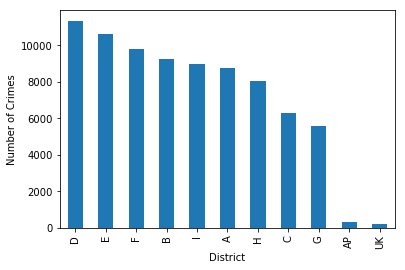

In [4]:
crime_district = crime['District'].value_counts()
crime_district.plot(kind='bar').set(xlabel="District", ylabel="Number of Crimes")

## Crime by Zip Code

- what zipcode had the most number of crimes? could we add this to a map of austin split by zipcode?
- http://www.zipmap.net/Texas/Travis_County/Austin.htm

[<matplotlib.text.Text at 0x11c04c450>, <matplotlib.text.Text at 0x11c030a90>]

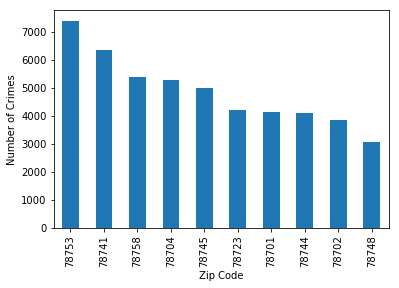

In [5]:
crime_zip = crime['Zipcode'].value_counts()
crime_zip[:10].plot(kind='bar').set(xlabel="Zip Code", ylabel="Number of Crimes")

## Frequency of Crimes 2014/2015

- should we edit data? many different kinds of theft

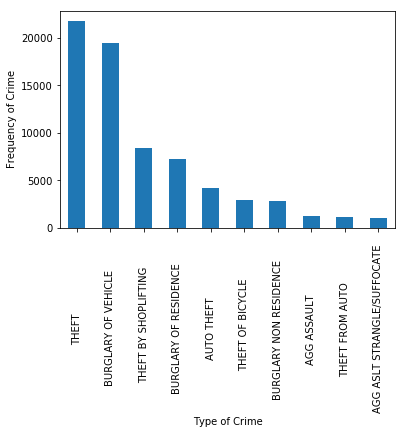

In [6]:
crime['Offense Description'].value_counts()

crime['Highest Offense Description'].value_counts()[:10].plot(kind="bar")
xlabel('Type of Crime')
ylabel('Frequency of Crime')

## Crime by Year

- similar counts

2014    40641
2015    38573
Name: Year, dtype: int64

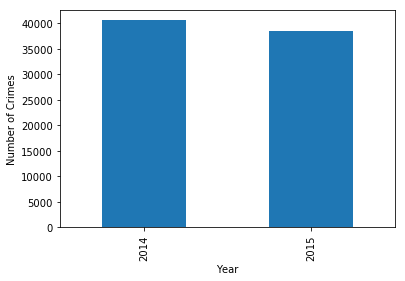

In [7]:
crime_year = crime['Year'].value_counts()
crime_year.plot(kind='bar').set(xlabel="Year", ylabel="Number of Crimes")
crime_year

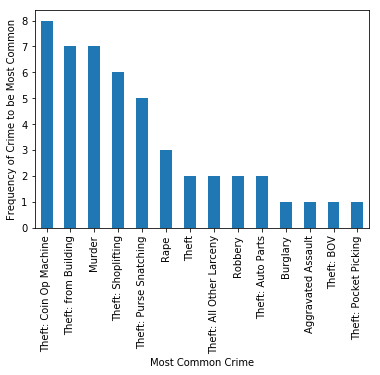

In [8]:
#most common crime per zipcode, plotted number of zipcodes that had certain most common crime

table = pd.crosstab(index=crime['Offense Description'],columns=crime['Zipcode'])
table
#print table.idxmax()
#not interesting--all theft--must normalize

violationFrequency = crime['Offense Description'].value_counts()
most_common_crimes_per_zip = (table.T / violationFrequency).idxmax(axis=1) #series
most_common_crimes_per_zip[:3]
common=pd.DataFrame(index=crime['Zipcode'].value_counts().index,columns=['Most Common Crime'])
#crime['Zipcode'].value_counts().index
common['Most Common Crime'] = most_common_crimes_per_zip
common['Most Common Crime'].value_counts().plot(kind='bar') #number of zipcodes that have these as the most common crimes
xlabel('Most Common Crime')
ylabel('Frequency of Crime to be Most Common')

## Crime by Month

In [9]:
#which crimes are most common in each month? normalized
table = pd.crosstab(index=crime['Offense Description'],columns=crime['Month'])
#print(table)
#print table.idxmax()
#not interesting--all theft--must normalize

violationFrequency = crime['Offense Description'].value_counts()
most_common_crimes_per_month = (table.T / violationFrequency).idxmax(axis=1) #series
most_common_crimes_per_month

common = pd.DataFrame(index=crime['Month'].value_counts().index,columns=['Most Common Crime'])
# #crime['Zipcode'].value_counts().index
common['Most Common Crime'] = most_common_crimes_per_month
#common.index=pd.CategoricalIndex(common.index,\
#                                 categories=['January', 'February', 'March', 'April','May','June', 'July',\
#                                             'August','September', 'October', 'November', 'December'], 
#                               sorted=True)

common = common.reindex(['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
common

#watch out for murders in November and December

,Most Common Crime
Jan,Theft: Purse Snatching
Feb,Theft: Coin Op Machine
Mar,Theft: Coin Op Machine
Apr,Theft: Purse Snatching
May,Theft: Purse Snatching
Jun,Theft: Purse Snatching
Jul,Theft: Coin Op Machine
Aug,Theft: Coin Op Machine
Sep,Murder
Oct,Theft: Purse Snatching


## Crime by Month 2014

Jan    3504
Feb    2958
Mar    3428
Apr    3395
May    3495
Jun    3348
Jul    3643
Aug    3546
Sep    3338
Oct    3505
Nov    3227
Dec    3254
Name: Month, dtype: int64


[<matplotlib.text.Text at 0x11ca953d0>, <matplotlib.text.Text at 0x11ca1f490>]

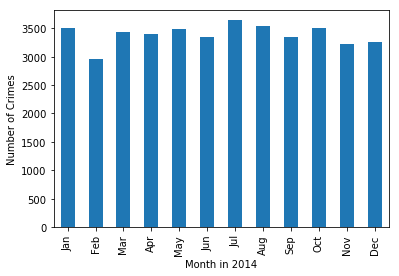

In [10]:
mask_2014 = crime['Year']==2014
crime_2014 = crime[mask_2014]
y2014_count = crime_2014['Month'].value_counts()
y2014_count = y2014_count.reindex(['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(y2014_count)
y2014_count.plot(kind='bar').set(xlabel="Month in 2014", ylabel="Number of Crimes")

## Crime by Month 2015

- always a drop in February
- always peaks in July

Jan    3067
Feb    2873
Mar    3203
Apr    3190
May    3349
Jun    3288
Jul    3524
Aug    3346
Sep    3166
Oct    3080
Nov    3168
Dec    3319
Name: Month, dtype: int64


[<matplotlib.text.Text at 0x11c53d8d0>, <matplotlib.text.Text at 0x11cb38510>]

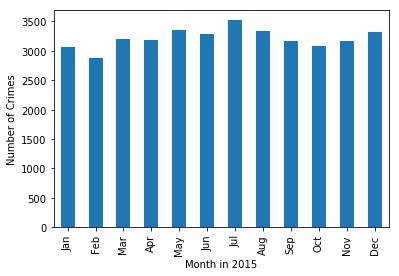

In [11]:
mask_2015 = crime['Year']==2015
crime_2015 = crime[mask_2015]
y2015_count = crime_2015['Month'].value_counts()
y2015_count = y2015_count.reindex(['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(y2015_count)
y2015_count.plot(kind='bar').set(xlabel="Month in 2015", ylabel="Number of Crimes")

## Clearance Frequencies

In [12]:
crime['Clearance Status'].value_counts() #most are not cleared :/ 
#look at crime type and clearance status 

#for each crime, what is the most common clearance status after normalizing? 
table = pd.crosstab(index=crime['Clearance Status'],columns=crime['Offense Description'])

violationFrequency = crime['Clearance Status'].value_counts()
most_common_status_per_crime = (table.T / violationFrequency).idxmax(axis=1) #series
most_common_status_per_crime
#O=cleared by exception, C- cleared by arrest, N- not cleared

Offense Description
Aggravated Assault          O
Burglary                    N
Murder                      C
Rape                        O
Robbery                     O
Theft                       N
Theft: All Other Larceny    N
Theft: Auto Parts           O
Theft: BOV                  N
Theft: Coin Op Machine      N
Theft: Pocket Picking       O
Theft: Purse Snatching      N
Theft: Shoplifting          C
Theft: from Building        N
dtype: object

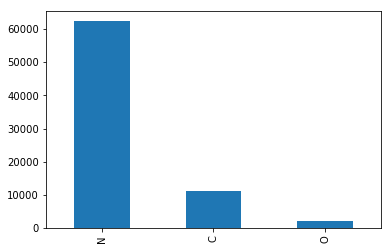

In [13]:
crime['Clearance Status'].value_counts().plot(kind='bar')
#the large majority of crimes are not cleared. why?

## Clearance Likelihood

In [14]:
#what crimes are most likely to not be cleared?
mask=(crime['Clearance Status']=='N')
crime[mask] #why do the not cleared have clearance dates? did they give up?
prob_crime_type_not_cleared=crime[mask]['Offense Description'].value_counts()/crime['Offense Description'].value_counts()
prob_crime_type_not_cleared.sort_values(ascending=False)
#purse snatching has never been cleared???  high non-clearance rates. murder is low 

Theft: Purse Snatching      1.000000
Theft: from Building        0.968326
Theft: BOV                  0.950972
Theft: Coin Op Machine      0.934641
Burglary                    0.872605
Theft: Pocket Picking       0.841518
Theft: All Other Larceny    0.839501
Theft: Auto Parts           0.824656
Theft                       0.815661
Robbery                     0.617468
Rape                        0.446257
Aggravated Assault          0.347620
Theft: Shoplifting          0.340570
Murder                      0.090909
Name: Offense Description, dtype: float64

In [15]:
#what crime is the most likely to be cleared by arrest?
prob_crime_type_cleared=crime[crime['Clearance Status']=='C']['Offense Description'].value_counts()\
                        /crime['Offense Description'].value_counts()
prob_crime_type_cleared.sort_values(ascending=False)
#Murder is the crime with the highest clearance rate- still only 60%. 

Murder                      0.600000
Theft: Shoplifting          0.563492
Aggravated Assault          0.476203
Robbery                     0.254837
Rape                        0.226488
Theft: Auto Parts           0.129141
Theft                       0.116609
Theft: All Other Larceny    0.094542
Burglary                    0.083986
Theft: Pocket Picking       0.069196
Theft: Coin Op Machine      0.039216
Theft: BOV                  0.022949
Theft: from Building        0.004525
Theft: Purse Snatching           NaN
Name: Offense Description, dtype: float64

In [16]:
#most likley crime to be cleared by exception
prob_crime_type_O=crime[crime['Clearance Status']=='O']['Offense Description'].value_counts()\
                        /crime['Offense Description'].value_counts()
prob_crime_type_O.sort_values(ascending=False)

Rape                        0.292706
Aggravated Assault          0.141467
Murder                      0.090909
Theft: Pocket Picking       0.051339
Robbery                     0.050304
Theft: Auto Parts           0.036060
Burglary                    0.024630
Theft: All Other Larceny    0.023266
Theft                       0.011106
Theft: from Building        0.009050
Theft: Coin Op Machine      0.006536
Theft: Shoplifting          0.006536
Theft: BOV                  0.002845
Theft: Purse Snatching           NaN
Name: Offense Description, dtype: float64

In [17]:
#adds column for number of days it took to clear
crime['Report Date']=pd.to_datetime(crime['Report Date'])
crime['Clearance Date']=pd.to_datetime(crime['Clearance Date'])
crime['Clearance Time']=crime['Clearance Date']-crime['Report Date']

crime['Clearance Time']=crime['Clearance Time'].dt.days #converted it to int
crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Highest Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,Offense Description,Date,Month,Year,Clearance Time
0,2014-04-28,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,2014-04-17,3135985,10117220,Robbery,2014-04-17,Apr,2014,11.0
1,2014-05-20,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,2014-04-25,3137985,10087946,Robbery,2014-04-25,Apr,2014,25.0
2,2014-05-13,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,2014-05-11,3120890,10068910,Robbery,2014-05-11,May,2014,2.0
3,2015-03-24,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,2014-06-16,3130566,10089446,Robbery,2014-06-16,Jun,2014,281.0
4,2014-10-02,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,2014-07-26,3117732,10068195,Robbery,2014-07-26,Jul,2014,68.0


In [18]:
mean_crime_clearance_time = crime.groupby(['Offense Description'])[['Clearance Time']].mean()
mean_crime_clearance_time.sort_values('Clearance Time')
#includes all crimes-- O and N and C

,Clearance Time
Offense Description,
Theft: BOV,8.272233
Theft: Coin Op Machine,10.353333
Theft: Purse Snatching,12.428571
Theft: Auto Parts,14.927368
Theft,15.228808
Theft: Pocket Picking,18.071926
Theft: All Other Larceny,18.499421
Theft: Shoplifting,19.222507
Aggravated Assault,19.431762


In [19]:
#avg clearance time for exception and arrest
mask=(crime['Clearance Status']=='N')
mean_crime_clearance_time = crime[~mask].groupby(['Offense Description'])[['Clearance Time']].mean()
mean_crime_clearance_time.sort_values('Clearance Time')
#are there any kinds of clearance standards to compare this to? to see how effective APD is in comparison

,Clearance Time
Offense Description,
Aggravated Assault,14.636441
Theft: Shoplifting,14.659705
Theft: Coin Op Machine,15.571429
Theft,15.589864
Theft: Pocket Picking,17.592593
Theft: BOV,20.485294
Theft: from Building,21.666667
Theft: All Other Larceny,24.755486
Theft: Auto Parts,25.892224


# Heavy Student Populated Areas
- mostly theft, 1 murder

/Users/shirley/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total crime count: 8491


Theft                 7243
Burglary               598
Aggravated Assault     300
Robbery                206
Rape                   141
Murder                   3
Name: Offense Description, dtype: int64


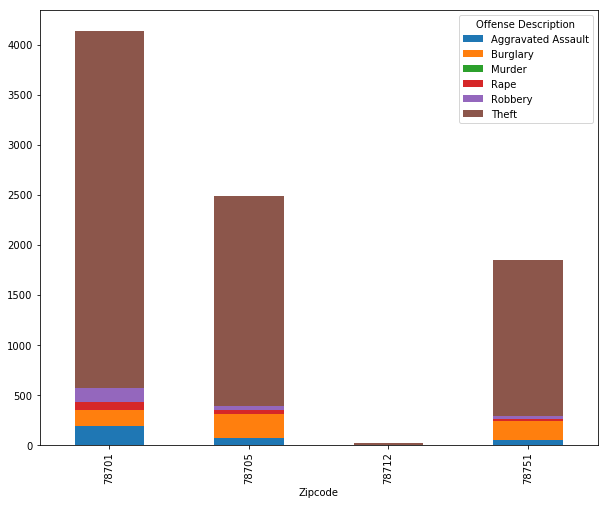

In [35]:
crime_wc = crime['Zipcode']=="78705"
crime_ut = crime['Zipcode']=="78712"
crime_hyde = crime['Zipcode']=="78751"
crime_dt = crime['Zipcode']=="78701"
area_mask = crime_wc | crime_ut | crime_hyde | crime_dt

#print(area_mask)

crime_student = crime[area_mask]


def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime_student['Offense Description'] = crime['Offense Description'].map(merge_theft)


#df2 = crime_student.groupby(['Zipcode', 'Offense Description'])['Zipcode'].count().unstack('Offense Description').fillna(0)
#df2[['Theft','Burglary']].plot(kind='bar', stacked=True)

pylab.rcParams['figure.figsize'] = (10, 8)

test5 = crime_student.groupby(['Zipcode', 'Offense Description'])['Zipcode'].count().unstack('Offense Description').fillna(0)
test5.plot(kind='bar', stacked=True)


# total crime count
print "Total crime count:", crime_student['Offense Description'].count()

# crime split into offenses
crime_student_vc = crime_student['Offense Description'].value_counts()
print "\n"
print(crime_student_vc)
#crime_student_vc.plot(kind='bar')


# UT Campus
- only 15 counts in 2 years
- all theft or robbery

In [ ]:
crime_wc = crime[crime['Zipcode']=="78712"]

# total crime count
print "Total crime count:", crime_wc['Offense Description'].count()

# crime split into offenses
crime_wc_vc = crime_wc['Offense Description'].value_counts()
print "\n"
print(crime_wc_vc)
crime_wc_vc.plot(kind='bar')


# Hyde Park
- still mostly theft
- areas near campus are largely safer than other areas in austin

In [ ]:
crime_wc = crime[crime['Zipcode']=="78751"]

# total crime count
print "Total crime count:", crime_wc['Offense Description'].count()

# crime split into offenses
crime_wc_vc = crime_wc['Offense Description'].value_counts()
print "\n"
print(crime_wc_vc)
crime_wc_vc.plot(kind='bar')


# Downtown
- much higher crime count
- more assault and rape, though still largely theft

In [ ]:
crime_wc = crime[crime['Zipcode']=="78701"]

# total crime count
print "Total crime count:", crime_wc['Offense Description'].count()

# crime split into offenses
crime_wc_vc = crime_wc['Offense Description'].value_counts()
print "\n"
print(crime_wc_vc)
crime_wc_vc.plot(kind='bar')
